# Import Packages

In [23]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create DataFrame with Images and Labels

In [24]:
data_path = "/kaggle/input/wheat-nitrogen-deficiency-and-leaf-rust-image/th422bg4yd-1/WheatLeafRust/train" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [25]:
data.head()


,image,label
0,/kaggle/input/wheat-nitrogen-deficiency-and-le...,diseased
1,/kaggle/input/wheat-nitrogen-deficiency-and-le...,diseased
2,/kaggle/input/wheat-nitrogen-deficiency-and-le...,diseased
3,/kaggle/input/wheat-nitrogen-deficiency-and-le...,diseased
4,/kaggle/input/wheat-nitrogen-deficiency-and-le...,diseased


In [26]:
data.tail()

,image,label
596,/kaggle/input/wheat-nitrogen-deficiency-and-le...,control
597,/kaggle/input/wheat-nitrogen-deficiency-and-le...,control
598,/kaggle/input/wheat-nitrogen-deficiency-and-le...,control
599,/kaggle/input/wheat-nitrogen-deficiency-and-le...,control
600,/kaggle/input/wheat-nitrogen-deficiency-and-le...,control


In [27]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.82, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [28]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (492, 2)
Validation set shape: (54, 2)
Test set shape: (55, 2)


In [29]:
batch_size = 32
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 492 validated image filenames belonging to 2 classes.
Found 54 validated image filenames belonging to 2 classes.
Found 55 validated image filenames belonging to 2 classes.


In [30]:
print(train_gen.class_indices)

{'control': 0, 'diseased': 1}


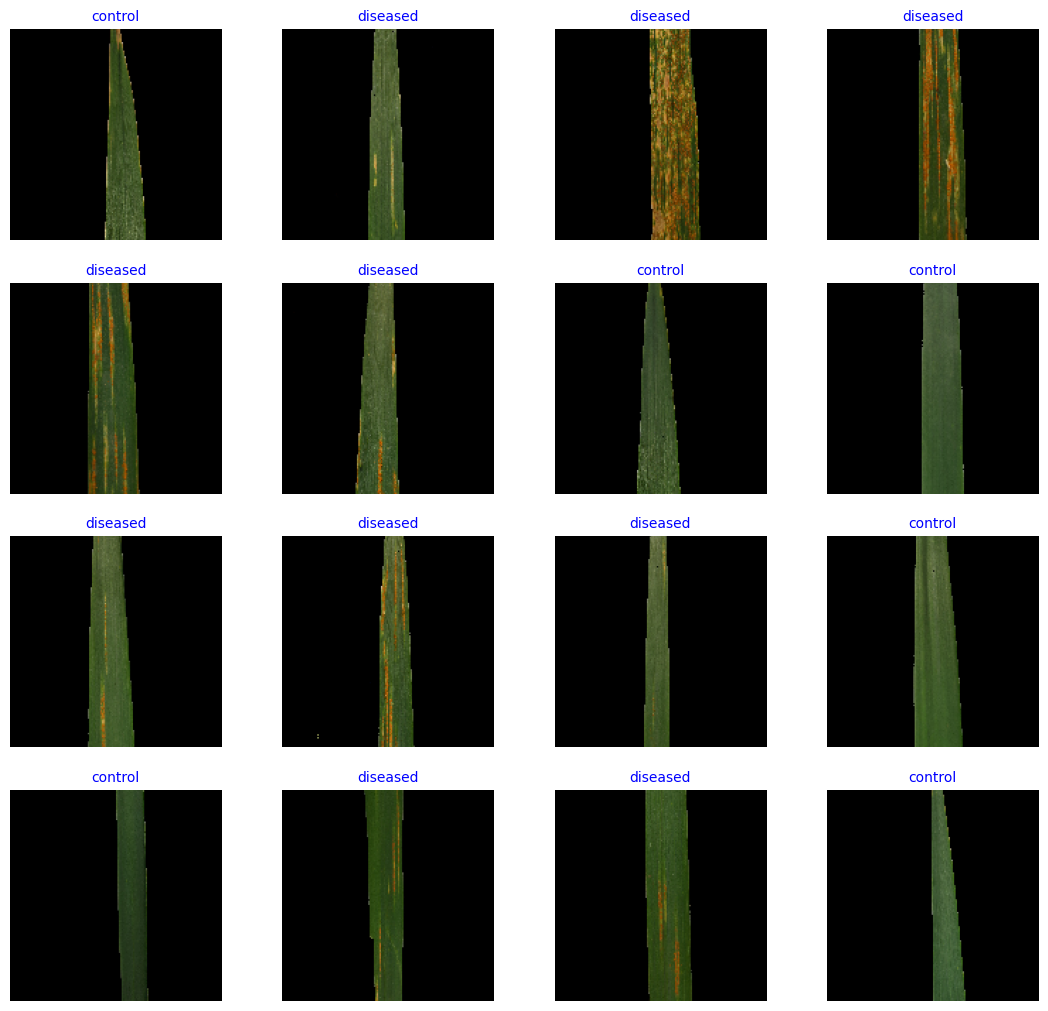

In [31]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

In [32]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.999) or (val_accuracy and val_accuracy > 0.999):
            print("\nReached 99.90% accuracy in training or validation, so cancelling training!")

# CNN Model

In [33]:
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D


n_classes = 2
input_shape = (150, 150, 3)

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())  
model.add(Dropout(0.35))

model.add(Conv2D(512, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())  
model.add(Dropout(0.35))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.add(Dense(n_classes, activation='sigmoid'))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 146, 146, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 146, 146, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 69, 69, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 69, 69, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 30, 30, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 30, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 13, 13, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,938,914 (7.40 MB)

 Trainable params: 1,936,930 (7.39 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


def lr_scheduler(epoch, lr):
    new_lr = lr * tf.math.exp(-0.1)
    return float(new_lr.numpy())

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.0001
)

callbacks = [
    myCallback(),
    LearningRateScheduler(lr_scheduler),
    reduce_lr
]

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=30,
    batch_size=32,
    verbose=2,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/30
Epoch 1: Training accuracy is 0.7866
Epoch 1: Validation accuracy is 0.4259
16/16 - 37s - 2s/step - accuracy: 0.7866 - loss: 5.9607 - val_accuracy: 0.4259 - val_loss: 11.4876 - learning_rate: 9.0484e-04
Epoch 2/30
Epoch 2: Training accuracy is 0.9106
Epoch 2: Validation accuracy is 0.4444
16/16 - 14s - 876ms/step - accuracy: 0.9106 - loss: 5.0293 - val_accuracy: 0.4444 - val_loss: 7.5523 - learning_rate: 8.1873e-04
Epoch 3/30
Epoch 3: Training accuracy is 0.9451
Epoch 3: Validation accuracy is 0.6296
16/16 - 14s - 880ms/step - accuracy: 0.9451 - loss: 4.4393 - val_accuracy: 0.6296 - val_loss: 4.9179 - learning_rate: 7.4082e-04
Epoch 4/30
Epoch 4: Training accuracy is 0.9411
Epoch 4: Validation accuracy is 0.4815
16/16 - 14s - 882ms/step - accuracy: 0.9411 - loss: 4.0095 - val_accuracy: 0.4815 - val_loss: 5.0489 - learning_rate: 6.7032e-04
Epoch 5/30
Epoch 5: Training accuracy is 0.9593
Epoch 5: Validation accuracy is 0.9630
16/16 - 15s - 922ms/step - accuracy: 0.9593 - loss:

# Accuracy and Loss Curve

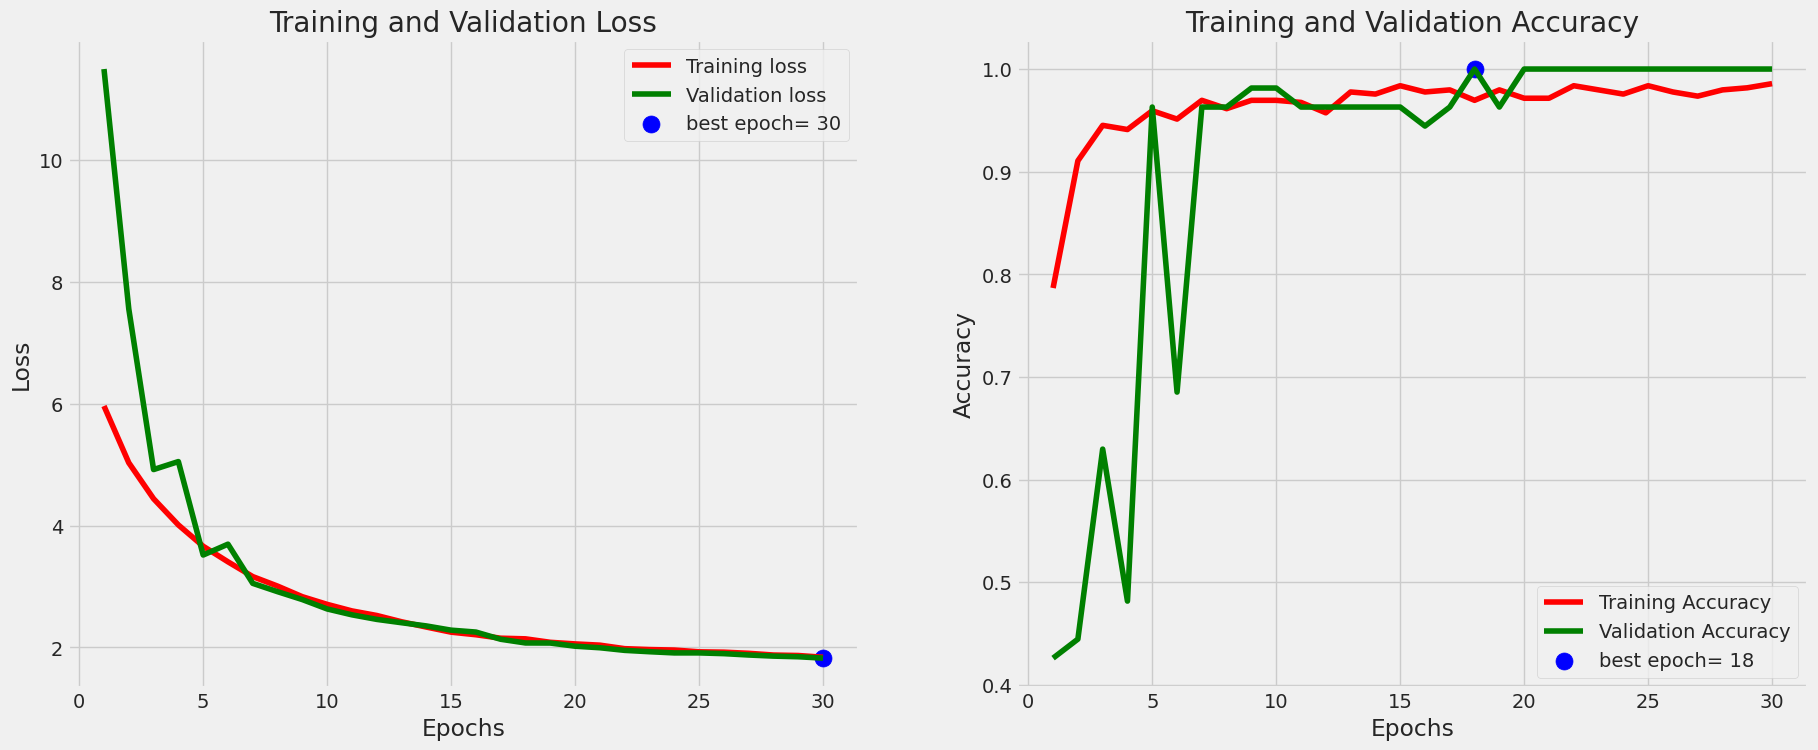

In [37]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

plt.savefig('training_validation_plots.png')
plt.show()

In [68]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step - accuracy: 1.0000 - loss: 1.8280
Accuracy score: 1.0


In [39]:
test_loss, test_accuracy = model.evaluate(test_gen)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9186 - loss: 1.9232  
Test accuracy: 0.9091
Test loss: 1.9360


In [40]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step - accuracy: 1.0000 - loss: 1.8091
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - accuracy: 1.0000 - loss: 1.8312
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step - accuracy: 0.9375 - loss: 1.8976
Train Loss:  1.8090770244598389
Train Accuracy:  1.0
--------------------
Valid Loss:  1.8312036991119385
Valid Accuracy:  1.0
--------------------
Test Loss:  1.8976398706436157
Test Accuracy:  0.9375


In [41]:
classes = list(test_gen.class_indices.keys())

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step
              precision    recall  f1-score   support

     control       0.86      1.00      0.93        31
    diseased       1.00      0.79      0.88        24

    accuracy                           0.91        55
   macro avg       0.93      0.90      0.90        55
weighted avg       0.92      0.91      0.91        55



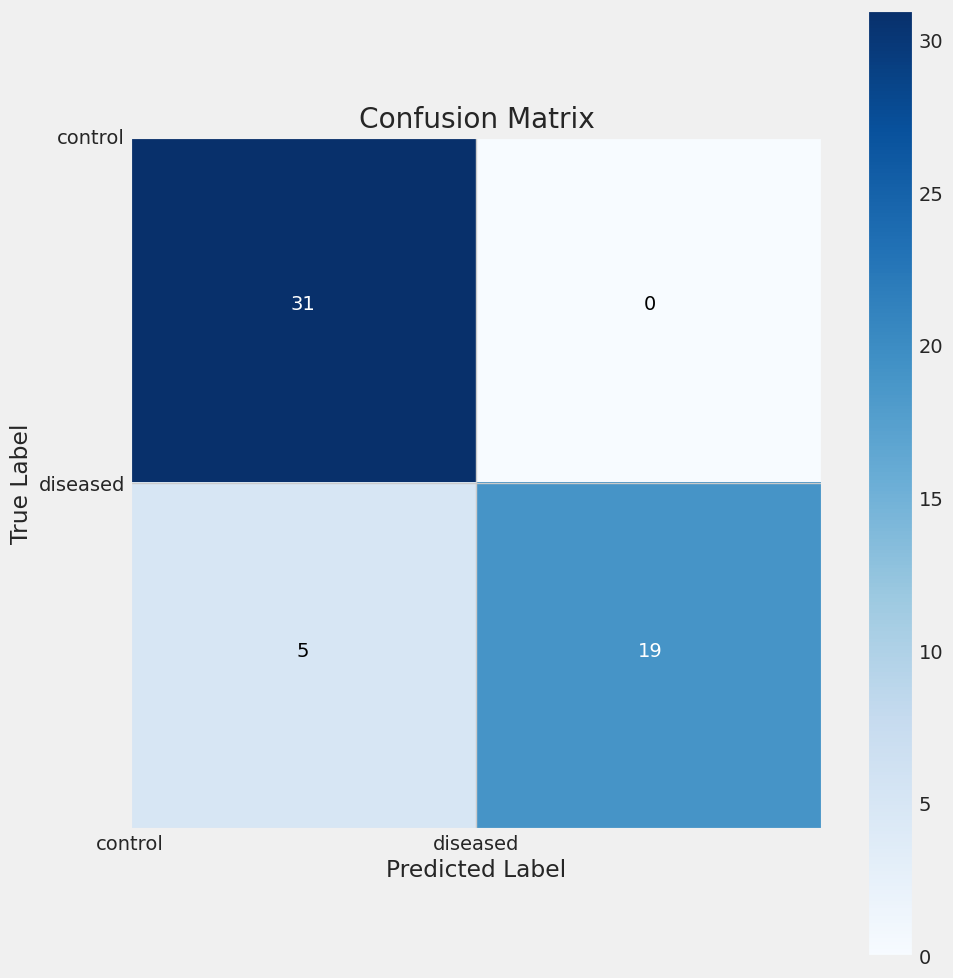

In [42]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [43]:
model.save('model1.h5')


# LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

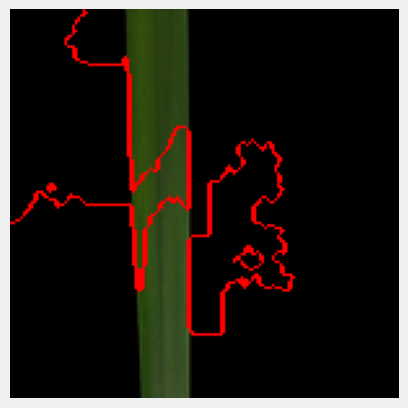

In [57]:
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

model = load_model('/kaggle/working/model1.h5')

explainer = lime.lime_image.LimeImageExplainer()

img_path = '/kaggle/input/wheat-nitrogen-deficiency-and-leaf-rust-image/th422bg4yd-1/WheatLeafRust/train/control/0.jpg'
img = Image.open(img_path).resize((150, 150))
img = np.array(img)

if len(img.shape) == 2:
    img = np.stack((img,)*3, axis=-1)

def predict_fn(images):
    images = np.array([preprocess_input(i.astype(np.float32)) for i in images])
    return model.predict(images)

explanation = explainer.explain_instance(
    img,  # ORIGINAL RGB image
    predict_fn,
    top_labels=5,
    hide_color=(255, 255, 255),  # white background
    num_samples=1000
)

# Visualize
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Show with red boundary
plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0)))  # red boundary
plt.axis('off')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

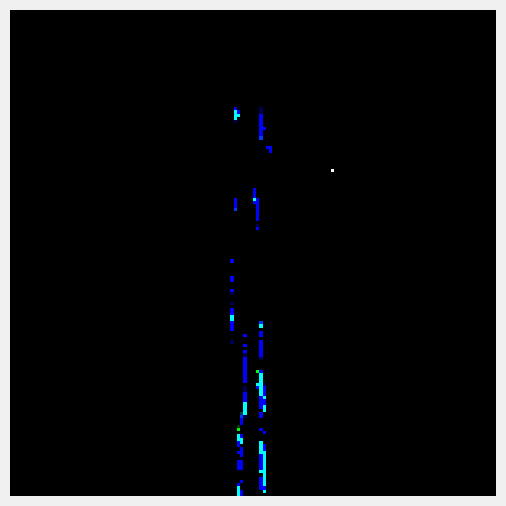

In [60]:
model = load_model('/kaggle/working/model1.h5')

explainer = lime.lime_image.LimeImageExplainer()

img_path = '/kaggle/input/wheat-nitrogen-deficiency-and-leaf-rust-image/th422bg4yd-1/WheatLeafRust/train/diseased/0.jpg'
img = Image.open(img_path).resize((150, 150))
img = np.array(img)

if len(img.shape) == 2:
    img = np.stack((img,)*3, axis=-1)

img = preprocess_input(img)

def predict_fn(images):
    processed_images = np.array([preprocess_input(image) for image in images])
    return model.predict(processed_images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=(255, 150, 155), num_samples=1000)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0], 
    positive_only=True, 
    num_features=10, 
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask, color=(1, 1, 0)))  
plt.axis('off')
plt.show()


# SHAP

  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.81s/it]               


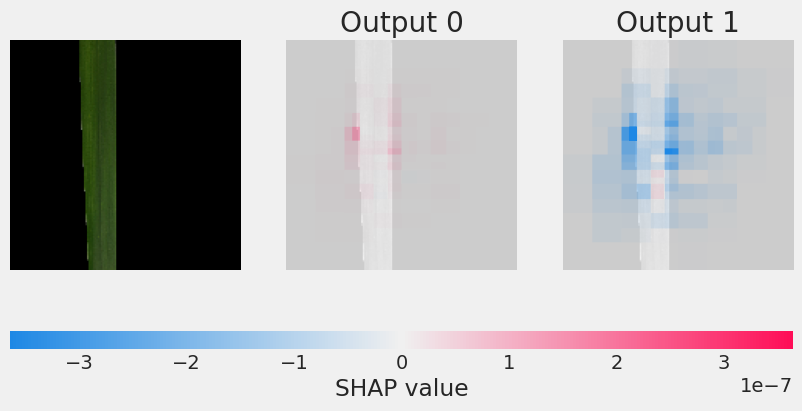

In [46]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/kaggle/input/wheat-nitrogen-deficiency-and-leaf-rust-image/th422bg4yd-1/WheatLeafRust/train"

image_path = '/kaggle/input/wheat-nitrogen-deficiency-and-leaf-rust-image/th422bg4yd-1/WheatLeafRust/train/control/0.jpg'

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [150, 150])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/model1.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(150,150)", shape=(150, 150, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=8000, outputs=shap.Explanation.argsort.flip[:8])

shap.image_plot(shap_values_fine)

#fig = plt.figure(figsize=(10, 10))
#shap.image_plot(shap_values_fine, show=False)
plt.show()

  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.45s/it]               


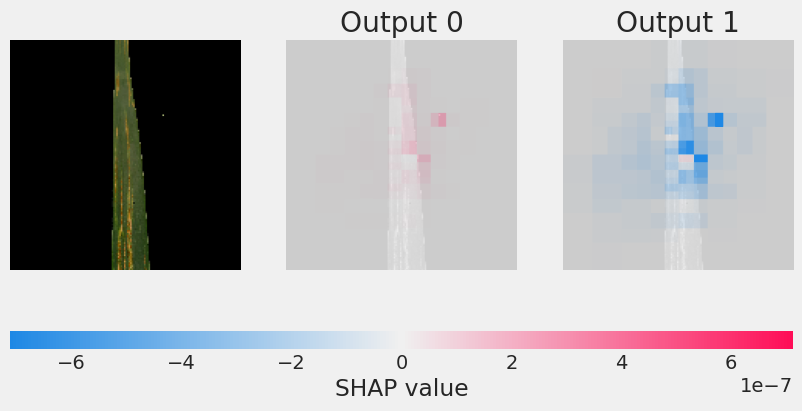

In [47]:
dataset_dir = "/kaggle/input/wheat-nitrogen-deficiency-and-leaf-rust-image/th422bg4yd-1/WheatLeafRust/train"

image_path = '/kaggle/input/wheat-nitrogen-deficiency-and-leaf-rust-image/th422bg4yd-1/WheatLeafRust/train/diseased/0.jpg'

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [150, 150])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/model1.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(150,150)", shape=(150, 150, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=8000, outputs=shap.Explanation.argsort.flip[:8])

shap.image_plot(shap_values_fine)

#fig = plt.figure(figsize=(10, 10))
#shap.image_plot(shap_values_fine, show=False)
plt.show()

# Saliency maps

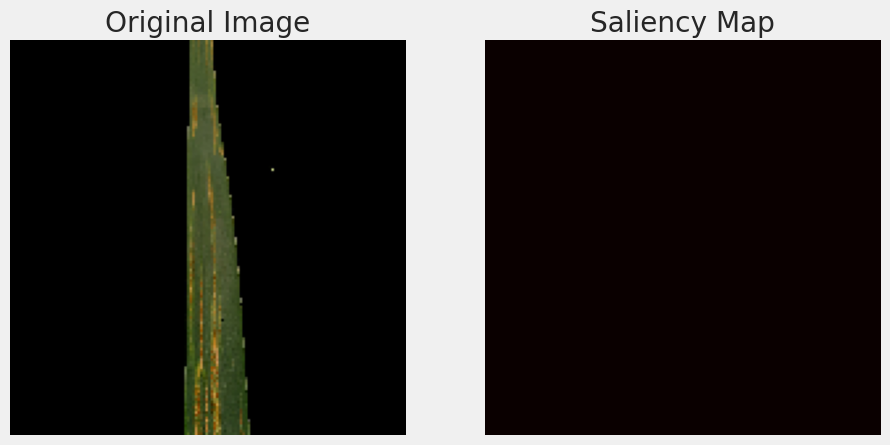

In [48]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


custom_model = load_model('/kaggle/working/model1.h5')

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)  
    return img_array

def compute_saliency_map(img_array, model):
    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        predicted_class = tf.argmax(preds[0])
        loss = preds[0, predicted_class]

    grads = tape.gradient(loss, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()
    return saliency

def display_saliency_map(saliency, img_path):
    img = image.load_img(img_path, target_size=(150, 150))  
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency[0], cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')
    plt.show()

image_path = '/kaggle/input/wheat-nitrogen-deficiency-and-leaf-rust-image/th422bg4yd-1/WheatLeafRust/train/control/0.jpg'
img_array = load_and_preprocess_image(img_path)
saliency = compute_saliency_map(img_array, custom_model)
display_saliency_map(saliency, img_path)

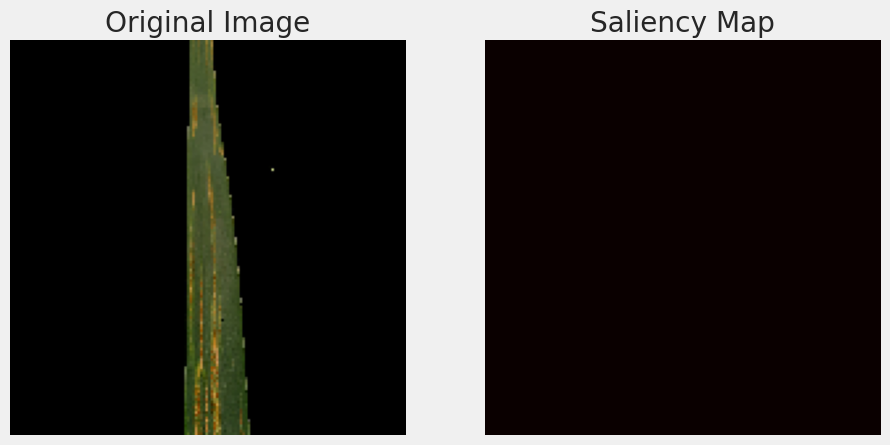

In [49]:
custom_model = load_model('/kaggle/working/model1.h5')

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)  
    return img_array

def compute_saliency_map(img_array, model):
    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        predicted_class = tf.argmax(preds[0])
        loss = preds[0, predicted_class]

    grads = tape.gradient(loss, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()
    return saliency

def display_saliency_map(saliency, img_path):
    img = image.load_img(img_path, target_size=(150, 150))  
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency[0], cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')
    plt.show()

image_path = '/kaggle/input/wheat-nitrogen-deficiency-and-leaf-rust-image/th422bg4yd-1/WheatLeafRust/train/diseased/0.jpg'
img_array = load_and_preprocess_image(img_path)
saliency = compute_saliency_map(img_array, custom_model)
display_saliency_map(saliency, img_path)

# EfficientNetB0

In [64]:
from tensorflow.keras.applications import EfficientNetB0

base_model_efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def build_efficientnetb0_model():
    x = base_model_efficientnetb0.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(2, activation='softmax')(x)

    model_efficientnetb0 = Model(inputs=base_model_efficientnetb0.input, outputs=output)
    model_efficientnetb0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
    return model_efficientnetb0

def train_and_evaluate_efficientnetb0(train_gen, valid_gen):
    print("Training EfficientNetB0...")
    
    model_efficientnetb0 = build_efficientnetb0_model()

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_efficientnetb0 = model_efficientnetb0.fit(
        train_gen,
        epochs=10,
        validation_data=valid_gen,
        callbacks=[reduce_lr]
    )

    val_loss, val_accuracy = model_efficientnetb0.evaluate(valid_gen)
    print(f"EfficientNetB0 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_efficientnetb0.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"EfficientNetB0 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_efficientnetb0(train_gen, valid_gen)

Training EfficientNetB0...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.6218 - loss: 0.6331 - val_accuracy: 0.4074 - val_loss: 0.8082 - learning_rate: 1.0000e-04
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 533ms/step - accuracy: 0.9417 - loss: 0.2299 - val_accuracy: 0.5370 - val_loss: 0.8032 - learning_rate: 1.0000e-04
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 606ms/step - accuracy: 0.9447 - loss: 0.1579 - val_accuracy: 0.5926 - val_loss: 0.7763 - learning_rate: 1.0000e-04
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 575ms/step - accuracy: 0.9774 - loss: 0.0671 - val_accuracy: 0.6296 - val_loss: 0.7691 - learning_rate: 1.0000e-04
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 536ms/step - accuracy: 0.9865 - loss: 0.0686 - val_accuracy: 0.6296 - val_loss: 0.8301 - learning_rate: 1.0000e-04
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 566ms/step - accuracy: 0.9953 - loss: 0.0380 - val_accuracy: 0.6296 - val_loss: 0.8809 - learning_rate: 1.0000e-04
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━

# Xception

In [65]:
from tensorflow.keras.applications import Xception

base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def build_xception_model():
    x = base_model_xception.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(2, activation='softmax')(x)

    model_xception = Model(inputs=base_model_xception.input, outputs=output)
    model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    return model_xception

def train_and_evaluate_xception(train_gen, valid_gen):
    print("Training Xception...")
    
    model_xception = build_xception_model()

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_xception = model_xception.fit(
        train_gen,
        epochs=10,
        validation_data=valid_gen,
        callbacks=[reduce_lr]
    )

    val_loss, val_accuracy = model_xception.evaluate(valid_gen)
    print(f"Xception Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_xception.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"Xception Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_xception(train_gen, valid_gen)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Xception...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6710 - loss: 0.6019 - val_accuracy: 0.6667 - val_loss: 0.6492 - learning_rate: 1.0000e-04
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 577ms/step - accuracy: 0.9642 - loss: 0.1410 - val_accuracy: 0.8148 - val_loss: 0.4349 - learning_rate: 1.0000e-04
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 617ms/step - accuracy: 0.9802 - loss: 0.0519 - val_accuracy: 0.8889 - val_loss: 0.4425 - learning_rate: 1.0000e-04
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 581ms/step - accuracy: 0.9981 - loss: 0.0242 - val_accuracy: 0.7963 - val_loss: 0.5427 - learning_rate: 1.0000e-04
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9922 - loss: 0.0287
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 558ms/step - accuracy: 0.9921 - loss: 0.0289 - val_accuracy: 0.8333 - val_loss: 0.4978 - learning_rate: 1.0000